In [111]:
import json
import os
import pandas as pd
import numpy as np
import prettytable as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")


###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
datadirectory=directory+"/data/yielddata.csv"


yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 

mdirectory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
mdatadirectory=mdirectory+"/data/marketdata.csv"

marketdata = pd.read_csv(mdatadirectory)
marketdata = marketdata.replace(np.nan, '', regex=True) 


vdirectory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
vdatadirectory=directory+"/data/swaptionvol.csv"

voldata = pd.read_csv(vdatadirectory)
voldata = voldata.replace(np.nan, '', regex=True) 

In [112]:
fixedleg={}
fixedleg["payOrReceive"]="Receive"
fixedleg["coupon"]= 0.085
fixedleg["frequency"]="Semiannual"
fixedleg["calendar"]="Turkey"
fixedleg["dateGeneration"]="Backward"
fixedleg["dayCounter"]="Actual360"
fixedleg["businessDayConvention"]="ModifiedFollowing"
fixedleg["maturityDateConvention"]="ModifiedFollowing"
fixedleg["endOfMonth"]=True
fixedleg

{'payOrReceive': 'Receive',
 'coupon': 0.085,
 'frequency': 'Semiannual',
 'calendar': 'Turkey',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'endOfMonth': True}

In [113]:
floatingleg={}
floatingleg["frequency"]="Quarterly"
floatingleg["spread"]=0.0
floatingleg["calendar"]="Turkey"
floatingleg["dateGeneration"]="Backward"
floatingleg["dayCounter"]="Actual360"
floatingleg["businessDayConvention"]="ModifiedFollowing"
floatingleg["maturityDateConvention"]="ModifiedFollowing"
floatingleg["endOfMonth"]=True
floatingleg["fixingDate"]=["2020-12-02"]
floatingleg["fixingRate"]=[0.0012428641149285805]
floatingleg

{'frequency': 'Quarterly',
 'spread': 0.0,
 'calendar': 'Turkey',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'endOfMonth': True,
 'fixingDate': ['2020-12-02'],
 'fixingRate': [0.0012428641149285805]}

In [114]:
instruments={}
depo={}
irs={}

depo["businessDayConvention"]="Following"     # if it is null, default value is used
depo["dayCounter"]="Actual360"                # if it is null, default value is used

irs["businessDayConvention"]="Following"      # if it is null, default value is used 
irs["dayCounter"]="Actual360"                 # if it is null, default value is used 
irs["frequency"]="Semiannual"               

instruments["DEPO"]=depo
instruments["IRS"]=irs

instruments

{'DEPO': {'businessDayConvention': 'Following', 'dayCounter': 'Actual360'},
 'IRS': {'businessDayConvention': 'Following',
  'dayCounter': 'Actual360',
  'frequency': 'Semiannual'}}

In [115]:
# Fix parameters for building yield curve
yieldcurveconfig={
      "name": "TRYZC",
      "settlementDays": 2,
      "intpMethod": "LINEAR",
      "currency": "TRY",
      "calendar": "Turkey",
      "dayCounter": "Actual360",
      "period": "6M",
      "instruments": instruments

    }
yieldcurveconfig

{'name': 'TRYZC',
 'settlementDays': 2,
 'intpMethod': 'LINEAR',
 'currency': 'TRY',
 'calendar': 'Turkey',
 'dayCounter': 'Actual360',
 'period': '6M',
 'instruments': {'DEPO': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360'},
  'IRS': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360',
   'frequency': 'Semiannual'}}}

In [116]:
riskdata = {
  "id": "PORTFOLIO1",
  "name": "PORTFOLIO 1",
  "method": "VaR",
  "forRisk": True,
  "valuationDate": "2021-01-28",
  "valuationCurrency": "TRY",
  "riskMethod": "MONTECARLO",
  "horizon": 252,
  "confidenceInterval": 0.99,
  "returnType": None,
  "trend": False,
  "calendar": "Turkey",
  "timeBucket": ["0D","1D","1W","2W","3W","1M","2M","3M","6M","9M","1Y","2Y","3Y","4Y",
                "5Y","6Y","7Y","8Y","9Y","10Y","12Y","15Y","20Y","25Y","30Y","40Y","50Y"],
  "fillNa": "BACKWARD",
  "maxFillNaDays": 5,
  "calibration": True,
  "correlation": False,
  "nPath": 1000,
  "nDayVar":2 ,
  "alpha": 0.376739,
  "sigma": 0.0209835,
  "tasks": [
        {
        'trade_id': 'IRS1000',
        'calculation_type': 'interest_rates_swap',
        'discountCurve': 'TRYZC',
        'floatingLegForecastCurve': 'TRYZC',
        'settlementDate': '2021-02-01',
        'maturityDate': '2026-06-04',
        'startDate': '2021-02-01',
        'notional': 1000000,
        'currency': 'TRY',
        'fixedLeg':fixedleg,
        'floatingLeg':floatingleg   
    }
  ],
  "curves": [yieldcurveconfig],
  "yieldData": yielddata.to_dict('r'),
  "marketData":marketdata.to_dict('r'),
  "volatilityData":voldata.to_dict('r'),
}

In [117]:
try:
    res = api.createTask(CalculationType.PORTFOLIO, riskdata, True)
    if(res["result"]):
      result=json.loads(res["result"])
    else:
      print(res["result"])
except RhoovaError as e:
    e.printPretty()

In [118]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['VAR', result.get('VaR')])
npvTable.add_row(['VAR/PV (%)', result.get('var/pv')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)


+------------+-------------+
| Parameters |       Value |
+------------+-------------+
|         PV | 425620.7501 |
|        VAR |    695.3979 |
| VAR/PV (%) |      0.1634 |
+------------+-------------+


In [119]:
irs=pd.DataFrame(result.get("portfolioPv"))
irs=irs.iloc[:,1:riskdata.get("nDayVar")]

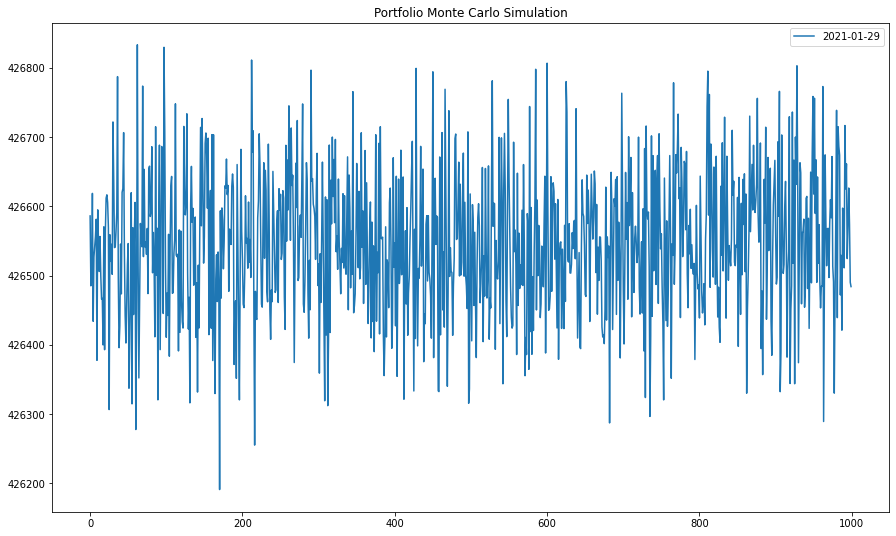

In [120]:
irs.plot(figsize=(15,9)); 
plt.title("Portfolio Monte Carlo Simulation")
plt.legend(loc='best')
plt.show()

In [121]:
irs.quantile(q=0.01, axis=0)-result.get('pv')

2021-01-29    695.397938
Name: 0.01, dtype: float64

In [122]:
pd.DataFrame(irs)

,2021-01-29
0,426586.082414
1,426485.156906
2,426492.303595
3,426618.631881
4,426433.947807
...,...
995,426570.730367
996,426626.378340
997,426573.831781
998,426490.217559
